# 2 - Variogram Models

This tutorial will guide you through the theoretical variogram models available for the `Variogram` class. 

**In this tutorial you will learn:**

* how to choose an appropiate model function
* how to judge fitting quality
* about sample size influence

In [1]:
from skgstat import Variogram, OrdinaryKriging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%env SKG_SUPPRESS = true

env: SKG_SUPPRESS=true


## 2.1 Load data

There are three prepared data sets in the `./data` folder. Each of them is a generated random field with different underlying spatial properties. We will use only the first one, but you can re-run all the examples with any of the other fields.

In [3]:
data1 = pd.read_csv('data/sample_matern_15.csv')
data2 = pd.read_csv('data/sample_matern_40.csv')
data3 = pd.read_csv('data/sample_spherical_noise.csv')

In [4]:
def plot_scatter(data, ax):
    art = ax.scatter(data.x, data.y, 50, c=data.z, cmap='plasma')
    plt.colorbar(art, ax=ax)

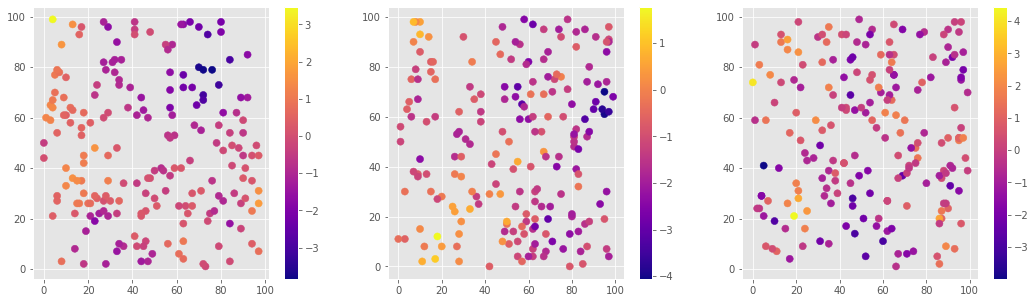

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for data, ax in zip((data1, data2, data3), axes.flatten()):
    plot_scatter(data, ax)

## 2.2 Comparing theoretical models

One of the features of `scikit-gstat` is the fact that it is programmed object oriented. That means, we can just instantiate a `Variogram` object and start changing arguments unitl it models spatial dependency in our observations well.

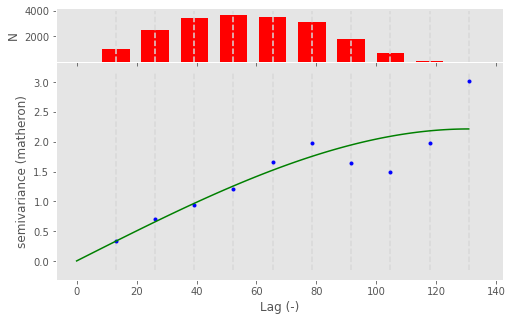

In [6]:
V1 = Variogram(data1[['x', 'y']].values, data1.z.values, normalize=False)
V1.plot(show=False);

The data set includes 200 observations, consequently we can increase the number of lag classes. Additionally, the histogram shows, that the lags over 100 units are backed up by just a few observations. Thus, we can limit the lag classes to at least 100.

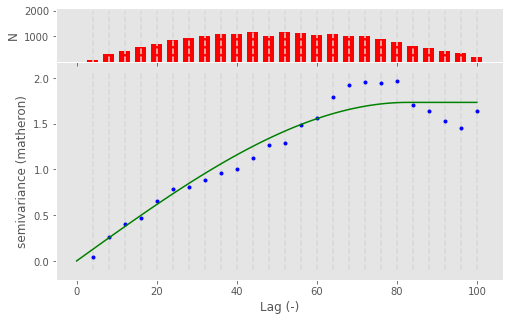

In [7]:
V1.maxlag = 100
V1.n_lags = 25
V1.plot(show=False);

That's not too bad. Now, we can try different theoretical models. It is always a good idea to judge the fit visually, Especially, because we want it to fit to close bins more accurately than to distant bins, as they will ultimately determine the Kriging weights. 
Nevertheless, `Variogram` has a `rmse` and a `r2` property, that can be used as a quality measure for the fit.
The `Variogram.plot` function also accepts one or two matplotlib subplot axes to plot the lag classes histogram and variogram plot into them. The histogram can also be turned off.

e:\dropbox\python\scikit-gstat\skgstat\models.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return func(*args, **kwargs)


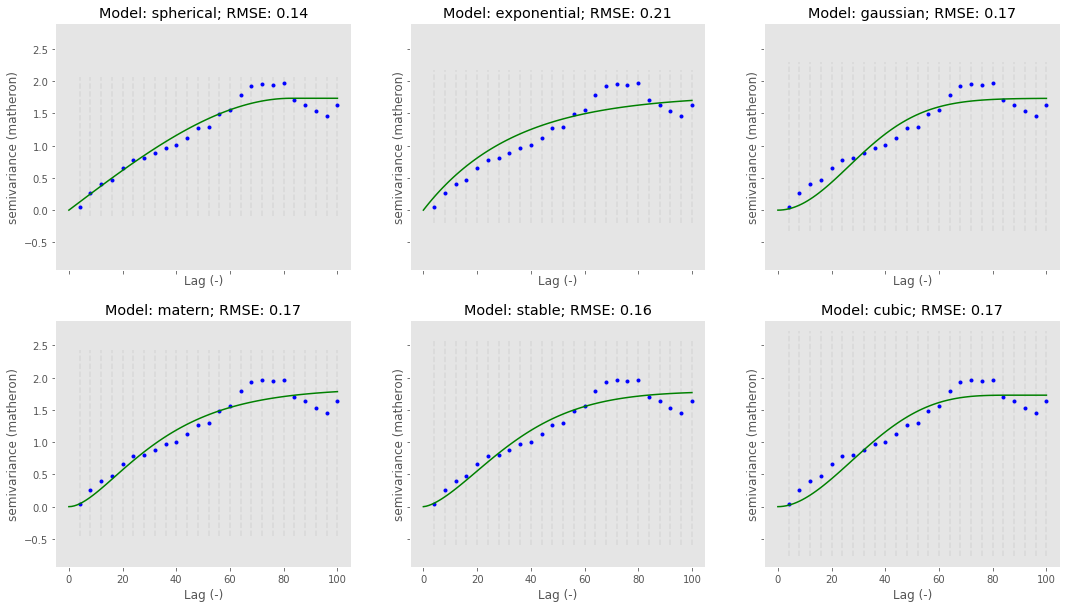

In [8]:
fig, _a = plt.subplots(2,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V1.model = model
    V1.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V1.rmse))

This is quite important. We find all 6 models to describe the experimental variogram equally well in terms of RMSE.
However, the `cubic` and `gaussian` model are off the experimental values almost all the time. On short distances, the model is underestimating and on medium distances (up to the effective range) it is overestimating. The `exponential` model is overestimating all the time. The `spherical`, `matern` and `stable` model seem to be pretty good on short distances.

But what does this difference look like, when it comes to interpolation?

In [9]:
def interpolate(V, ax):
    xx, yy = np.mgrid[0:99:100j, 0:99:100j]
    ok = OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    art = ax.matshow(field, origin='lower', cmap='plasma')
    ax.set_title('%s model' % V.model.__name__)
    plt.colorbar(art, ax=ax)
    return field

e:\dropbox\python\scikit-gstat\skgstat\models.py:14: RuntimeWarning: invalid value encountered in double_scalars
  mapping = map(lambda h: func(h, *new_args, **kwargs), args[0])


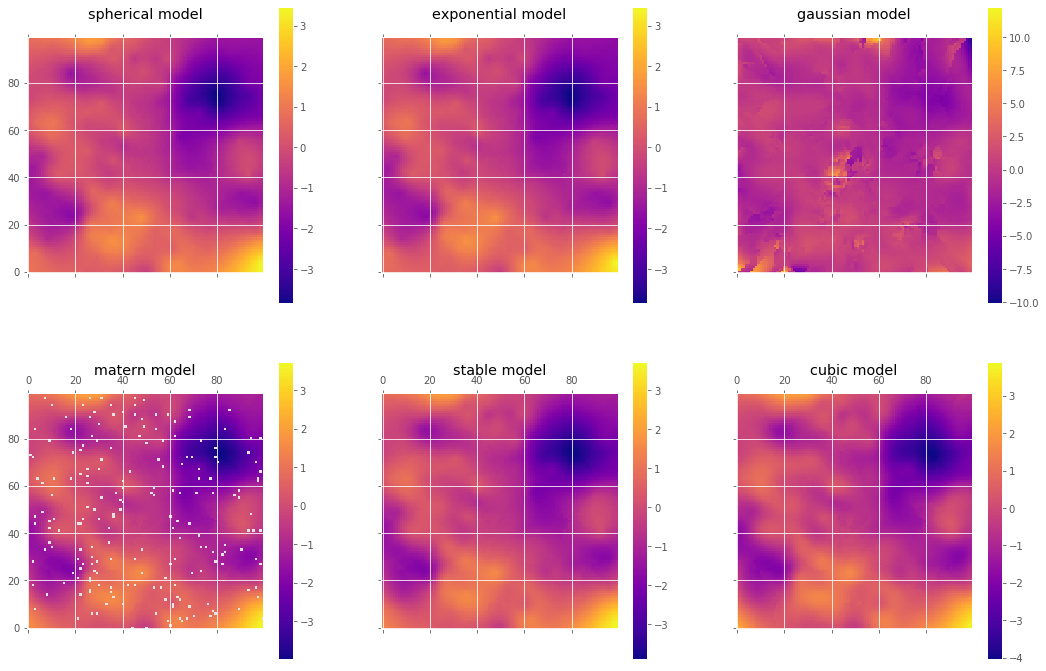

In [10]:
fields = []
fig, _a = plt.subplots(2,3, figsize=(18, 12), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V1.model = model
    fields.append(interpolate(V1, axes[i]))

In [11]:
pd.DataFrame({'spherical': fields[0].flatten(), 'exponential': fields[1].flatten(), 'gaussian': fields[2].flatten(),
              'matern': fields[3].flatten(), 'stable': fields[4].flatten(), 'cubic': fields[5].flatten()}).describe()

,spherical,exponential,gaussian,matern,stable,cubic
count,10000.000000,10000.000000,10000.000000,9800.000000,10000.000000,10000.000000
mean,-0.422579,-0.427136,-0.376234,-0.422088,-0.419537,-0.412559
std,1.106599,1.101533,1.546581,1.157061,1.140925,1.165185
min,-3.841342,-3.841342,-10.081703,-3.977538,-3.893159,-4.030550
25%,-1.096673,-1.093462,-1.227488,-1.123188,-1.117248,-1.088648
50%,-0.313185,-0.313439,-0.301236,-0.295343,-0.307810,-0.289786
75%,0.301038,0.297955,0.502080,0.327033,0.322166,0.333818
max,3.467911,3.467911,12.305929,3.727784,3.718852,3.887957


While most of the results look fairly similar there are a few things to notice:

1. Gaussian model is far off, producing estimations far outside the observed value ranges
2. All other models produce quite comparable numbers
3. The Matérn model fails, when recalculating the observations themselves

You have to remind that we had quite some observations. How does that look like, when the number of observations is decreased?

## 2.3 Using less observations

### 2.3.1 50% of all observations

In this section we will run the same code, but on just a quarter and 10% of all available observations. First, we look into the variograms:

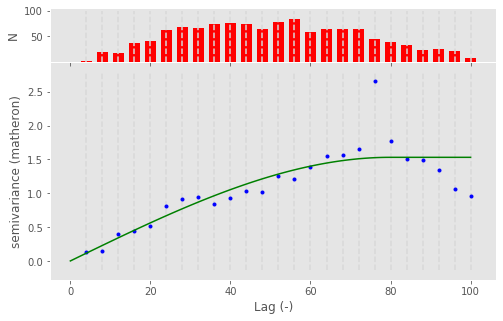

In [12]:
subset1 = data1.iloc[:50]
V2 = Variogram(subset1[['x', 'y']].values, subset1.z.values, normalize=False, maxlag=100, n_lags=25)
V2.plot(show=False);

e:\dropbox\python\scikit-gstat\skgstat\models.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return func(*args, **kwargs)


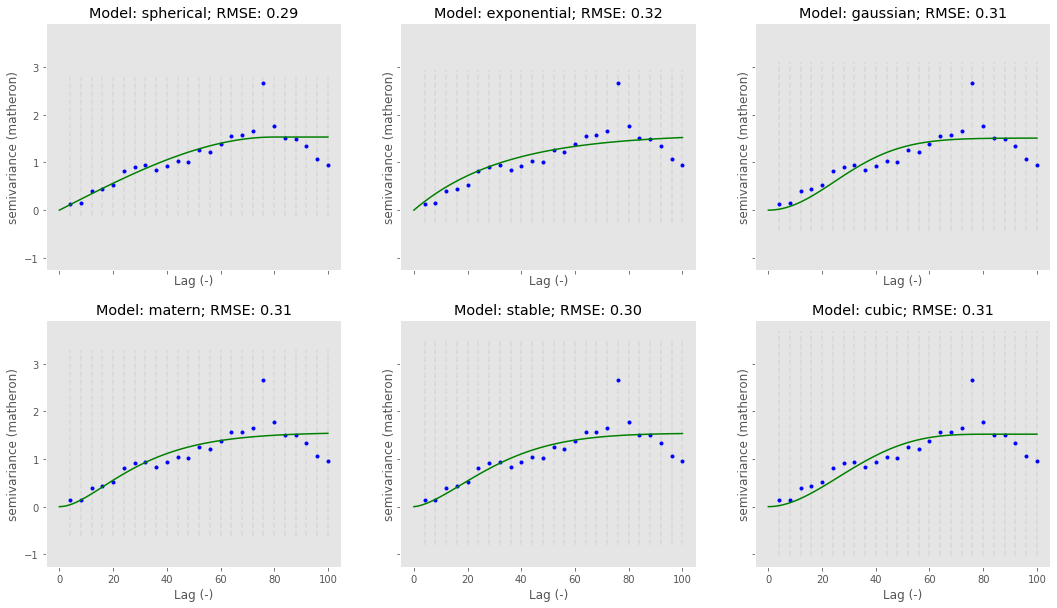

In [13]:
fig, _a = plt.subplots(2,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V2.model = model
    V2.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V2.rmse))

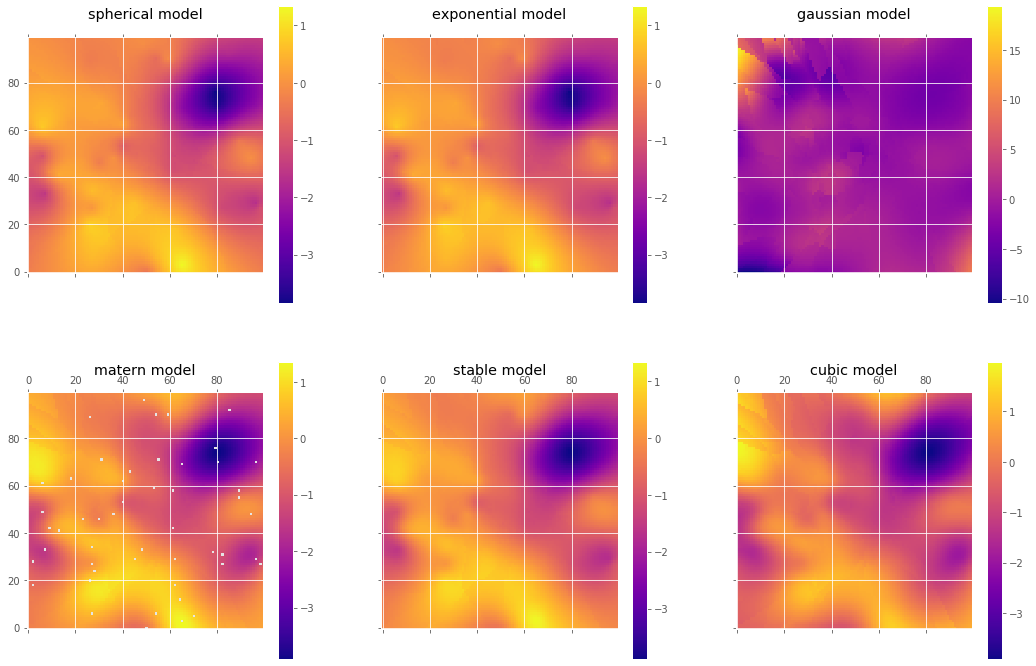

In [14]:
fields = []
fig, _a = plt.subplots(2,3, figsize=(18, 12), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V2.model = model
    fields.append(interpolate(V2, axes[i]))

In [15]:
pd.DataFrame({'spherical': fields[0].flatten(), 'exponential': fields[1].flatten(), 'gaussian': fields[2].flatten(),
              'matern': fields[3].flatten(), 'stable': fields[4].flatten(), 'cubic': fields[5].flatten()}).describe()

,spherical,exponential,gaussian,matern,stable,cubic
count,10000.000000,10000.000000,10000.000000,9950.000000,10000.000000,10000.000000
mean,-0.492584,-0.498393,-0.229285,-0.474786,-0.482607,-0.436488
std,0.933770,0.913543,2.596812,1.022044,0.987613,1.093714
min,-3.841342,-3.841342,-10.442055,-3.908236,-3.883908,-3.907538
25%,-0.968383,-0.961082,-1.519022,-1.008619,-0.981728,-1.026079
50%,-0.250866,-0.263681,-0.489828,-0.286338,-0.271219,-0.307099
75%,0.179633,0.159811,0.737149,0.265865,0.228785,0.352761
max,1.331839,1.331839,19.360127,1.346393,1.331839,1.973759


* The Gaussian model is of course still far off
* All other models struggle in hitting the high values. They are far off on the upper bound.

### 2.3.1 10% of all observations

In this section we will run the same code, but on just a quarter and 10% of all available observations. First, we look into the variograms:

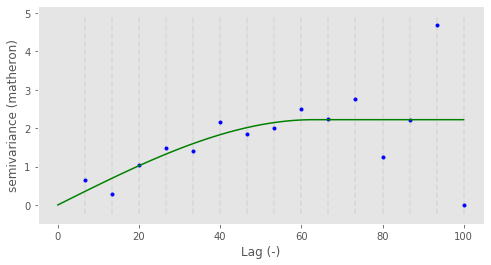

In [16]:
subset2 = data1.iloc[180:]
V3 = Variogram(subset2[['x', 'y']].values, subset2.z.values, normalize=False, maxlag=100, n_lags=15)
V3.plot(hist=False, show=False);

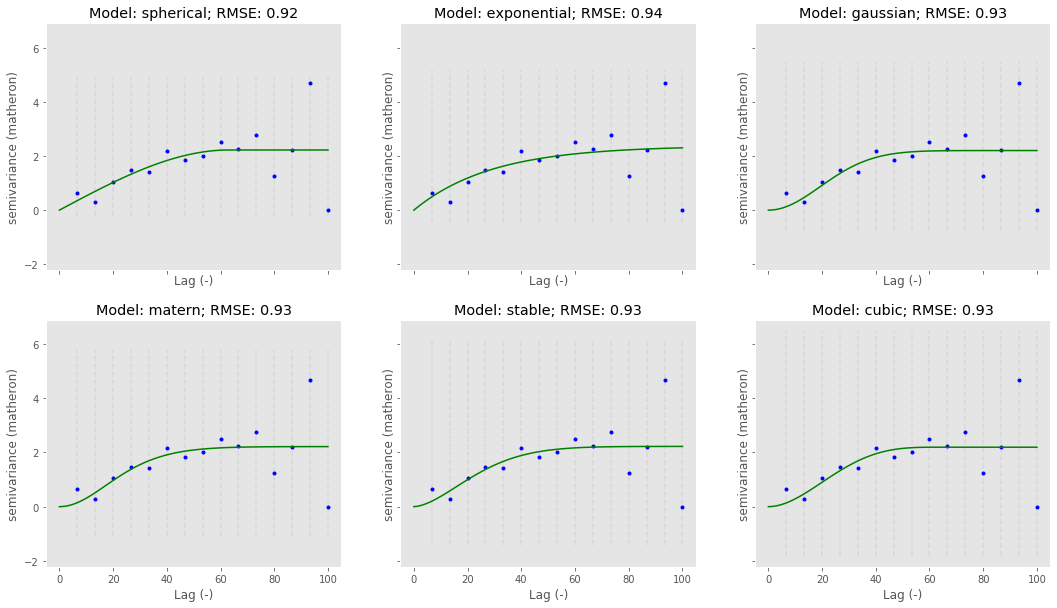

In [17]:
fig, _a = plt.subplots(2,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V3.model = model
    V3.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V3.rmse))

In this example, we were basing the variogram analysis on only 20 observations. That is a number that could be considered to be the lower bound of geostatistics. The RMSE values are decreasing as the experimental variograms are more scattered. However, All six models seem to fit fairly well to the experimental data. It is hard to tell from just the figure above which is correct.

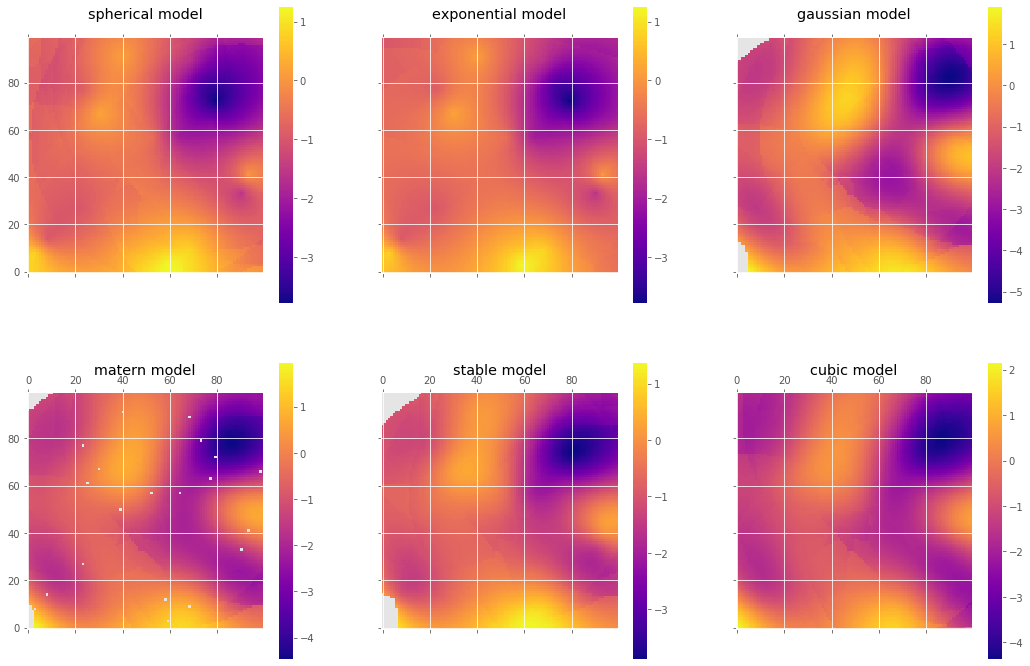

In [18]:
fields = []
fig, _a = plt.subplots(2,3, figsize=(18, 12), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V3.model = model
    fields.append(interpolate(V3, axes[i]))

In [19]:
pd.DataFrame({'spherical': fields[0].flatten(), 'exponential': fields[1].flatten(), 'gaussian': fields[2].flatten(),
              'matern': fields[3].flatten(), 'stable': fields[4].flatten(), 'cubic': fields[5].flatten()}).describe()

,spherical,exponential,gaussian,matern,stable,cubic
count,10000.000000,10000.000000,9856.000000,9904.000000,9786.000000,10000.000000
mean,-0.808890,-0.793323,-1.094349,-0.994542,-0.899081,-1.058428
std,0.887960,0.820827,1.366513,1.127764,0.948683,1.124708
min,-3.785324,-3.785324,-5.277685,-4.458332,-3.880787,-4.364176
25%,-1.063349,-1.033391,-1.904575,-1.629145,-1.314486,-1.698163
50%,-0.671072,-0.621459,-0.963145,-0.899756,-0.801062,-1.004205
75%,-0.288246,-0.334686,-0.125231,-0.207966,-0.277770,-0.275732
max,1.259305,1.259305,1.914923,1.960789,1.380699,2.162505


Here, some interesting things happend:

1. The Gaussian model is performing well again.
2. There are substantial differences between the interpolation results
3. In many runs, NaN values were produced, because not enough neighbors could be found

We decreased the number of observations so far, that the `max_points` attribute came into effect. In the other cases the Kriging interpolator found so many close observations, that limiting them to 15 had the effect, that estimations were usually derived from obserations within a few units. Now, even if enough points are within the range, we use observations from medium distances. Here, the different shapes of the models come into effect, as could be seen from the last example. 